# F1Ops Cost & Emissions Analysis

This notebook explores the cost structure and environmental impact of F1 team logistics.

**Version**: 0.1 (Feb 2020)
**Focus**: Road freight analysis

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from f1ops.data_loader import get_european_races
from f1ops.geo import build_season_legs
from f1ops.cost import calculate_leg_cost, calculate_season_cost, estimate_travel_hours
from f1ops.emissions import calculate_leg_emissions, calculate_season_emissions
from f1ops.config import DEFAULT_COST_PARAMS, DEFAULT_EMISSIONS_PARAMS

%matplotlib inline
sns.set_style('whitegrid')

## 1. Cost Model Parameters

Our cost model includes multiple components:
- **Fuel**: Diesel consumption based on distance
- **Labor**: Driver wages (2 drivers per truck)
- **Tolls**: Road usage fees
- **Fixed**: Administrative, permits, insurance

In [2]:
# Display default parameters
params = DEFAULT_COST_PARAMS

print("Fleet Configuration:")
print(f"  Number of trucks:    {params['num_trucks']}")
print(f"\nFuel Parameters:")
print(f"  Consumption:         {params['fuel_consumption_l_per_100km']} L/100km")
print(f"  Price:               €{params['fuel_price_eur_per_l']:.2f}/L")
print(f"\nLabor Parameters:")
print(f"  Drivers per truck:   2")
print(f"  Wage:                €{params['driver_wage_eur_per_hour']:.2f}/hour")
print(f"  Average speed:       {params['avg_speed_kmh']} km/h")
print(f"\nOther Costs:")
print(f"  Toll rate:           €{params['toll_eur_per_km']:.2f}/km per truck")
print(f"  Fixed cost per leg:  €{params['fixed_cost_per_leg_eur']:.2f}")

Fleet Configuration:
  Number of trucks:    8.0

Fuel Parameters:
  Consumption:         30.0 L/100km
  Price:               €1.50/L

Labor Parameters:
  Drivers per truck:   2
  Wage:                €35.00/hour
  Average speed:       80.0 km/h

Other Costs:
  Toll rate:           €0.25/km per truck
  Fixed cost per leg:  €500.00


## 2. Load 2019 Season Data

In [3]:
races_2019 = get_european_races(2019)
legs = build_season_legs(races_2019)

print(f"Loaded {len(races_2019)} races, {len(legs)} legs")

Loaded 8 races, 7 legs


## 3. Calculate Costs for Each Leg

In [4]:
# Calculate costs
leg_data = []
num_trucks = int(params['num_trucks'])

for leg in legs:
    cost = calculate_leg_cost(leg, num_trucks, params)
    leg_data.append({
        'leg_name': leg.leg_name,
        'distance_km': leg.distance_km,
        'fuel_cost': cost.fuel_cost_eur,
        'labor_cost': cost.labor_cost_eur,
        'toll_cost': cost.toll_cost_eur,
        'fixed_cost': cost.fixed_cost_eur,
        'total_cost': cost.total_cost_eur
    })

df_costs = pd.DataFrame(leg_data)
df_costs.head(10)

,leg_name,distance_km,fuel_cost,labor_cost,toll_cost,fixed_cost,total_cost
0,Montmeló → Monte Carlo,486.50,1751.40,3405.50,973.00,500.0,6629.90
1,Monte Carlo → Le Castellet,142.29,512.24,996.03,284.58,500.0,2292.85
2,Le Castellet → Spielberg,830.48,2989.73,5813.36,1660.96,500.0,10964.05
3,Spielberg → Hockenheim,516.20,1858.32,3613.40,1032.40,500.0,7004.12
4,Hockenheim → Budapest,813.11,2927.20,5691.77,1626.22,500.0,10745.19
5,Budapest → Spa,1020.44,3673.58,7143.08,2040.88,500.0,13357.54
6,Spa → Monza,589.58,2122.49,4127.06,1179.16,500.0,7928.71


## 4. Cost Component Breakdown

In [5]:
# Aggregate costs
total_fuel = df_costs['fuel_cost'].sum()
total_labor = df_costs['labor_cost'].sum()
total_toll = df_costs['toll_cost'].sum()
total_fixed = df_costs['fixed_cost'].sum()
total_cost = df_costs['total_cost'].sum()

print("2019 Season Cost Breakdown:")
print(f"  Fuel:       €{total_fuel:>12,.2f}  ({total_fuel/total_cost*100:5.1f}%)")
print(f"  Labor:      €{total_labor:>12,.2f}  ({total_labor/total_cost*100:5.1f}%)")
print(f"  Tolls:      €{total_toll:>12,.2f}  ({total_toll/total_cost*100:5.1f}%)")
print(f"  Fixed:      €{total_fixed:>12,.2f}  ({total_fixed/total_cost*100:5.1f}%)")
print(f"  {'─'*40}")
print(f"  TOTAL:      €{total_cost:>12,.2f}")

2019 Season Cost Breakdown:
  Fuel:       €   15,834.96  ( 26.9%)
  Labor:      €   30,790.20  ( 52.3%)
  Tolls:      €    8,797.20  ( 14.9%)
  Fixed:      €    3,500.00  (  5.9%)
  ────────────────────────────────────────
  TOTAL:      €   58,922.36


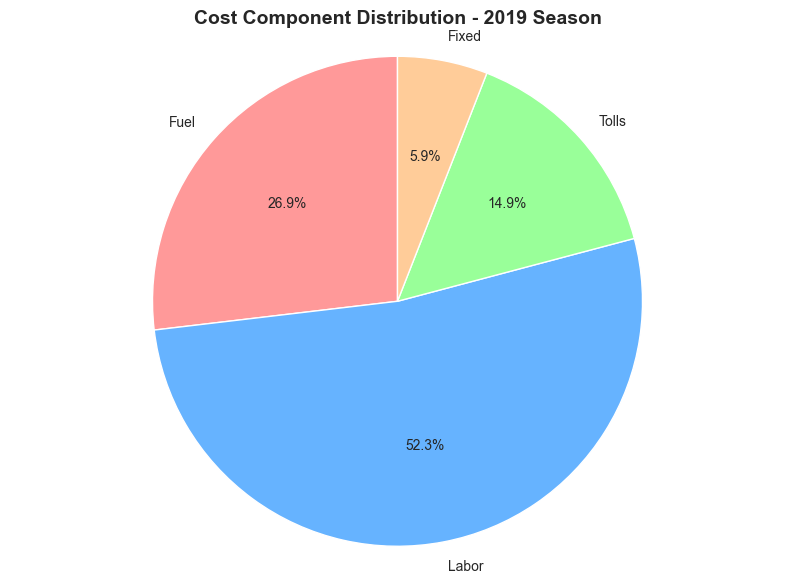

In [6]:
# Pie chart of cost components
costs = [total_fuel, total_labor, total_toll, total_fixed]
labels = ['Fuel', 'Labor', 'Tolls', 'Fixed']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

plt.figure(figsize=(10, 7))
plt.pie(costs, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Cost Component Distribution - 2019 Season', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

## 5. Cost per Leg Analysis

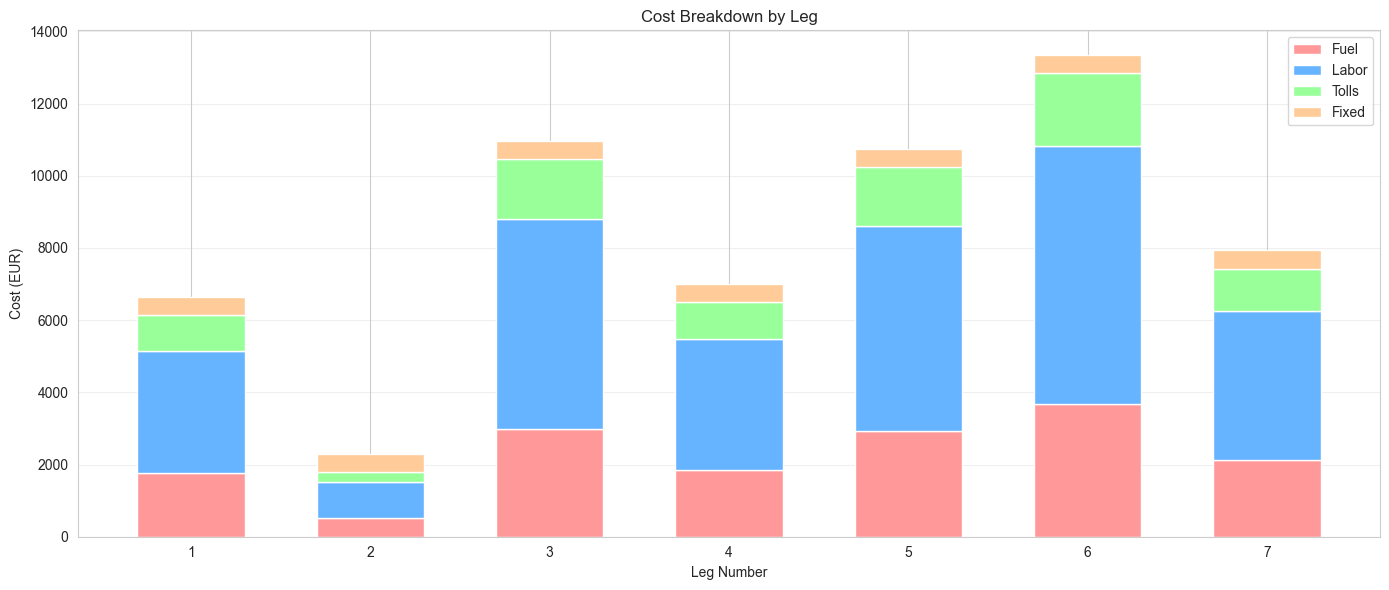

In [7]:
# Bar chart of costs per leg
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(df_costs))
width = 0.6

# Stacked bar chart
ax.bar(x, df_costs['fuel_cost'], width, label='Fuel', color='#ff9999')
ax.bar(x, df_costs['labor_cost'], width, bottom=df_costs['fuel_cost'], label='Labor', color='#66b3ff')
ax.bar(x, df_costs['toll_cost'], width, 
       bottom=df_costs['fuel_cost'] + df_costs['labor_cost'], label='Tolls', color='#99ff99')
ax.bar(x, df_costs['fixed_cost'], width,
       bottom=df_costs['fuel_cost'] + df_costs['labor_cost'] + df_costs['toll_cost'],
       label='Fixed', color='#ffcc99')

ax.set_xlabel('Leg Number')
ax.set_ylabel('Cost (EUR)')
ax.set_title('Cost Breakdown by Leg')
ax.set_xticks(x)
ax.set_xticklabels([f'{i+1}' for i in range(len(df_costs))])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Cost vs Distance Correlation

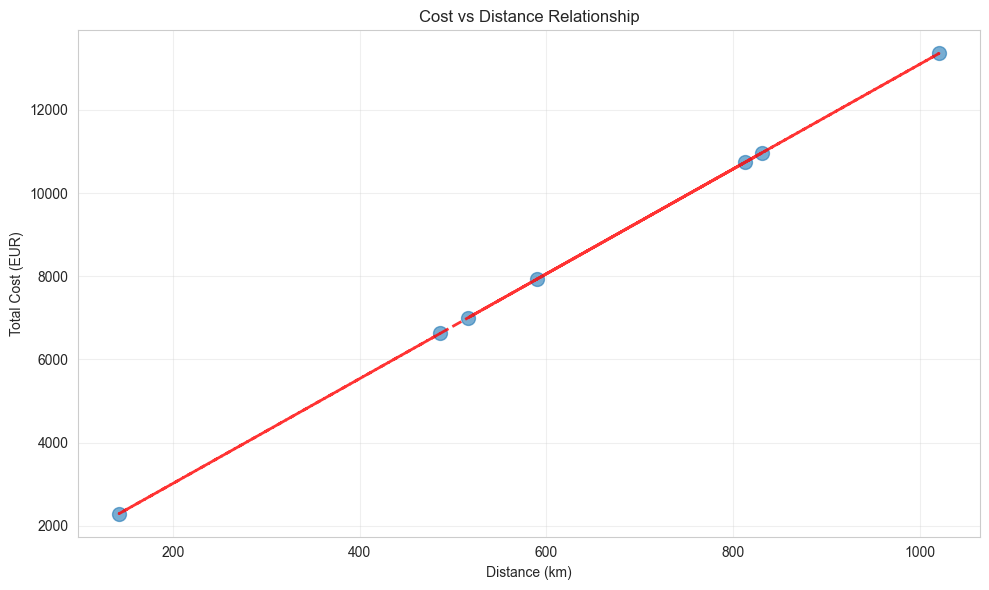

Correlation coefficient: 1.000


In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df_costs['distance_km'], df_costs['total_cost'], s=100, alpha=0.6)

# Add trend line
z = np.polyfit(df_costs['distance_km'], df_costs['total_cost'], 1)
p = np.poly1d(z)
plt.plot(df_costs['distance_km'], p(df_costs['distance_km']), "r--", alpha=0.8, linewidth=2)

plt.xlabel('Distance (km)')
plt.ylabel('Total Cost (EUR)')
plt.title('Cost vs Distance Relationship')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df_costs['distance_km'].corr(df_costs['total_cost'])
print(f"Correlation coefficient: {correlation:.3f}")

## 7. Emissions Analysis

In [9]:
emissions_params = DEFAULT_EMISSIONS_PARAMS

print("Emissions Parameters:")
print(f"  Road freight: {emissions_params['road_freight_g_co2e_per_km']} g CO2e/km per truck")
print(f"  Air fraction: {emissions_params['air_freight_fraction']*100:.0f}%")

Emissions Parameters:
  Road freight: 850.0 g CO2e/km per truck
  Air fraction: 0%


In [10]:
# Calculate emissions
emissions_data = []

for leg in legs:
    emissions = calculate_leg_emissions(leg, params['num_trucks'], emissions_params)
    emissions_data.append({
        'leg_name': leg.leg_name,
        'distance_km': leg.distance_km,
        'co2e_tonnes': emissions.total_co2e_kg / 1000  # Convert to tonnes
    })

df_emissions = pd.DataFrame(emissions_data)

total_emissions = df_emissions['co2e_tonnes'].sum()
print(f"\nTotal 2019 Season Emissions: {total_emissions:.2f} tonnes CO2e")


Total 2019 Season Emissions: 29.91 tonnes CO2e


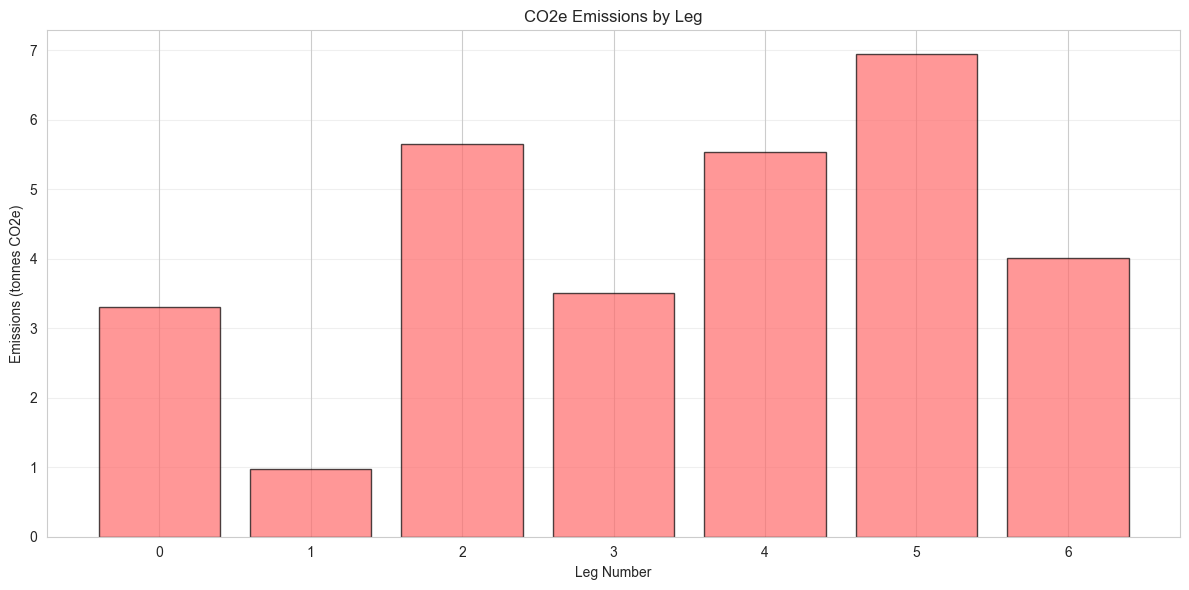

In [11]:
# Emissions by leg
plt.figure(figsize=(12, 6))
plt.bar(range(len(df_emissions)), df_emissions['co2e_tonnes'], color='#ff6b6b', alpha=0.7, edgecolor='black')
plt.xlabel('Leg Number')
plt.ylabel('Emissions (tonnes CO2e)')
plt.title('CO2e Emissions by Leg')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 8. Cost per Tonne CO2e

In [12]:
cost_per_tonne_co2e = total_cost / total_emissions

print(f"Cost efficiency: €{cost_per_tonne_co2e:,.2f} per tonne CO2e")
print(f"\nInterpretation: Each euro spent results in {1/cost_per_tonne_co2e*1000:.2f} kg CO2e emissions")

Cost efficiency: €1,969.96 per tonne CO2e

Interpretation: Each euro spent results in 0.51 kg CO2e emissions


## Summary

This notebook demonstrated:
- Multi-component cost modeling (fuel, labor, tolls, fixed)
- Cost distribution analysis across the season
- Strong correlation between distance and cost
- CO2e emissions calculations for road freight
- Cost-emissions efficiency metrics

**Key Findings**:
- Labor typically dominates cost structure (due to dual-driver requirements)
- Fixed costs become more significant for shorter legs
- Emissions scale linearly with distance for road freight

**Next**: Fleet optimization strategies